
--- K-Means Clustering ---
K-Means Silhouette Score: 0.6015198890061298

--- K-Means Cluster Definitions ---
Cluster 0:
d0_session_duration      452.550596
fp_offer_type             10.986854
lt_first_geo_tier          3.018129
d0_level                   1.286138
lt_first_channel_type      0.996607
Name: 0, dtype: float64 

Cluster 1:
d0_session_duration      2226.621614
fp_offer_type              10.709400
d0_level                    3.389785
lt_first_channel_type       1.598372
lt_first_geo_tier           1.291636
Name: 1, dtype: float64 

Cluster 2:
d0_session_duration    7007.021053
first_list_price         50.323605
d0_level                  9.260526
fp_offer_type             8.278947
lt_first_geo_tier         1.642105
Name: 2, dtype: float64 


--- Hierarchical Clustering ---


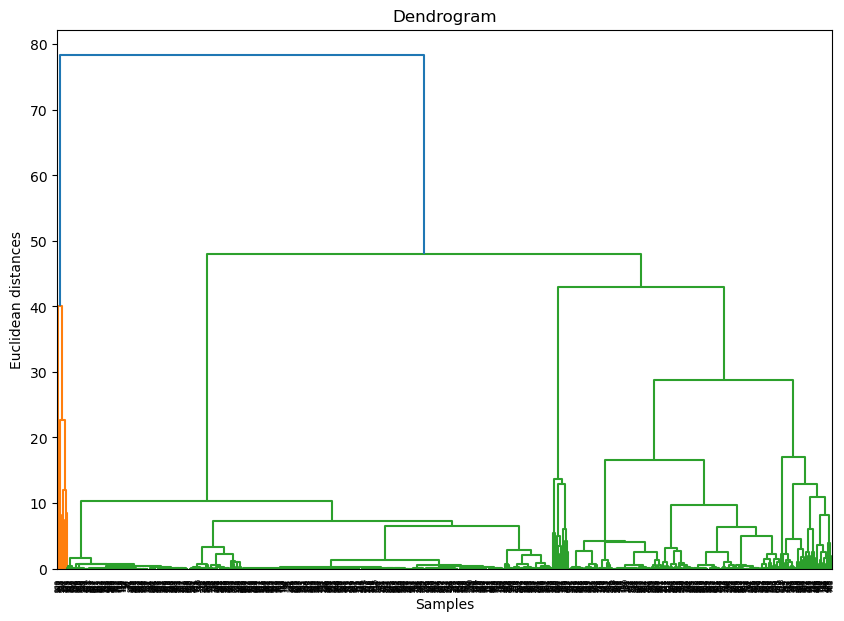

Hierarchical Silhouette Score: 0.47100509827469045

--- Hierarchical Cluster Definitions ---
Cluster 0:
d0_session_duration      1641.946737
fp_offer_type              10.789488
d0_level                    2.688392
lt_first_geo_tier           1.628208
lt_first_channel_type       1.356548
Name: 0, dtype: float64 

Cluster 1:
d0_session_duration    9258.355469
first_list_price         71.694961
d0_level                 12.238281
fp_offer_type             7.726562
kmeans_cluster            2.000000
Name: 1, dtype: float64 

Cluster 2:
d0_session_duration      357.868867
fp_offer_type             10.999721
lt_first_geo_tier          3.304069
d0_level                   1.176565
lt_first_channel_type      0.995394
Name: 2, dtype: float64 


--- Random Forest Classifier ---
Random Forest Accuracy: 0.9721153846153846

--- Random Forest Insights ---
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99      5071
        True   

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, silhouette_score
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Load data in chunks for memory efficiency
chunk_size = 20000
chunks = pd.read_csv('/Users/joel.saetern/Downloads/bq-results-20241214-021555-1734142662890.csv', chunksize=chunk_size)

# Sample 50,000 rows from chunks
sampled_data = pd.concat([chunk.sample(n=min(chunk_size // 10, len(chunk)), random_state=42) for chunk in chunks])

# Drop unnecessary columns
sampled_data.drop(columns=['b_product_name', 'd7_is_active', 'd14_is_active', 'user_id'], inplace=True)

# Encode categorical data
label_encoders = {}
for column in sampled_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    sampled_data[column] = le.fit_transform(sampled_data[column].astype(str))
    label_encoders[column] = le

# Ensure fp_offer_type is treated as categorical if not already
if 'fp_offer_type' in sampled_data.columns:
    sampled_data['fp_offer_type'] = sampled_data['fp_offer_type'].astype('category').cat.codes

# Fill missing values appropriately
sampled_data.fillna(sampled_data.median(), inplace=True)

# Define target variable and features
target = 'd30_is_active'
X = sampled_data.drop(columns=[target])
y = sampled_data[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction for clustering
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# --- Clustering ---

# K-Means Clustering
print("\n--- K-Means Clustering ---")
kmeans = KMeans(n_clusters=3, random_state=42)
sampled_data['kmeans_cluster'] = kmeans.fit_predict(X_pca)

# Evaluate K-Means
silhouette_kmeans = silhouette_score(X_pca, sampled_data['kmeans_cluster'])
print(f"K-Means Silhouette Score: {silhouette_kmeans}")

# K-Means Cluster Interpretation
kmeans_insights = sampled_data.groupby('kmeans_cluster').mean()
print("\n--- K-Means Cluster Definitions ---")
for cluster_id, data in kmeans_insights.iterrows():
    print(f"Cluster {cluster_id}:")
    print(data.sort_values(ascending=False).head(5), "\n")

# Hierarchical Clustering
print("\n--- Hierarchical Clustering ---")
dendrogram_sample = X_pca[:1000]  # Use a reduced sample for dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(dendrogram_sample, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')  # 'affinity' is deprecated and removed
sampled_data['hierarchical_cluster'] = hierarchical.fit_predict(X_pca)

# Evaluate Hierarchical Clustering
silhouette_hierarchical = silhouette_score(X_pca, sampled_data['hierarchical_cluster'])
print(f"Hierarchical Silhouette Score: {silhouette_hierarchical}")

# Hierarchical Cluster Interpretation
hierarchical_insights = sampled_data.groupby('hierarchical_cluster').mean()
print("\n--- Hierarchical Cluster Definitions ---")
for cluster_id, data in hierarchical_insights.iterrows():
    print(f"Cluster {cluster_id}:")
    print(data.sort_values(ascending=False).head(5), "\n")

# --- Supervised Learning ---

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
print("\n--- Random Forest Classifier ---")
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print("\n--- Random Forest Insights ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print("Top Features Contributing to Random Forest:")
print(feature_importances.head(10), "\n")

# Logistic Regression
print("\n--- Logistic Regression ---")
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=5000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print("\n--- Logistic Regression Insights ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

coefficients = pd.DataFrame(lr.coef_[0], index=X.columns, columns=['Coefficient']).sort_values('Coefficient', ascending=False)
print("Top Positive Features in Logistic Regression:")
print(coefficients.head(10), "\n")
print("Top Negative Features in Logistic Regression:")
print(coefficients.tail(10), "\n")
